In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exercice 1 — Régression : Prédiction du tarif d’un trajet Uber


## Étape 1 : Chargement et exploration du jeu de données

In [ ]:
# Set the path to the file you'd like to load
file_path = "uber.csv"

# Load the latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "yasserh/uber-fares-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


data.head()

/tmp/ipython-input-198593293.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  data = kagglehub.load_dataset(


Using Colab cache for faster access to the 'uber-fares-dataset' dataset.


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


## Étape 2 : Nettoyage et préparation

In [ ]:
import pandas as pd

data = data.dropna()
data = data[data['fare_amount'] > 0]
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

## Étape 3 : Séparation des données

In [ ]:
import numpy as np

def calculate_haversine_distance(data):
    """
    Calculates the Haversine distance in kilometers between pickup and dropoff
    coordinates in a DataFrame.
    """
    # Earth's mean radius in kilometers
    R = 6371

    # 1. Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(data['pickup_latitude'])
    lon1_rad = np.radians(data['pickup_longitude'])
    lat2_rad = np.radians(data['dropoff_latitude'])
    lon2_rad = np.radians(data['dropoff_longitude'])

    # 2. Calculate the change in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # 3. Apply the Haversine formula for 'a'
    # a = sin²(Δlat/2) + cos(lat1) * cos(lat2) * sin²(Δlon/2)
    a = (np.sin(dlat / 2)**2 +
         np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2)

    # 4. Calculate 'c'
    # c = 2 * atan2(√a, √(1-a))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # 5. Calculate the distance 'd'
    # d = R * c
    distance = R * c

    return distance

# --- How to use it ---

# Assuming your DataFrame is named 'data':
# This will create a new 'distance' column or overwrite the existing one.
data['distance'] = calculate_haversine_distance(data)

# print(data[['pickup_latitude', 'dropoff_latitude', 'distance', 'distance_calculated']].head())

In [ ]:
from sklearn.model_selection import train_test_split
X = data[['distance', 'hour', 'day_of_week']]
y = data['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Étape 4 : Entraînement du modèle

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Étape 5 : Évaluation du modèle

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('MAE =', mae)
print('RMSE =', rmse)
print('R² =', r2)

MAE = 6.024606980536918
RMSE = 9.635978518193681
R² = 0.0014590917488973565


## Étape 6 : Amélioration avec Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Étape 7 : Visualisation des résultats

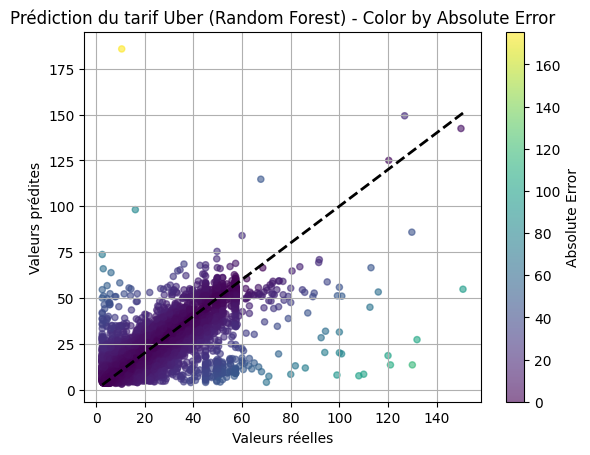

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the absolute error
abs_error = np.abs(y_test_finite - y_pred_rf) # Use y_test_finite to match y_pred_rf

plt.scatter(y_test_finite, y_pred_rf, c=abs_error, cmap='viridis', alpha=0.6, s=20) # Color by absolute error
plt.plot([y_test_finite.min(), y_test_finite.max()], [y_test_finite.min(), y_test_finite.max()], 'k--', lw=2) # Add a diagonal line for perfect predictions
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédiction du tarif Uber (Random Forest) - Color by Absolute Error')
plt.colorbar(label='Absolute Error') # Add a color bar
plt.grid(True) # Add a grid for better readability
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print('MAE =', mae)
print('RMSE =', rmse)
print('R² =', r2)

MAE = 2.6764387331965507
RMSE = 5.252214573531149
R² = 0.7033399016974249


# Exercice 2 — Classification : Prédire la survie sur le Titanic

## Étape 1 : Chargement et exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('train.csv')
print(data.head())
print(data.info())
print(data.isnull().sum())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

## Étape 2 : Nettoyage et traitement

In [ ]:
data = data[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

## Étape 3 : Encodage des variables catégorielles

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'])

## Étape 4 : Séparation des données

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Étape 5 : Entraînement des modèles

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Étape 6 : Évaluation des modèles

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
print('Accuracy (Logistic):', accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print('Accuracy (Random Forest):', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy (Logistic): 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy (Random Forest): 0.8212290502793296
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



## Étape 7 : Matrice de confusion

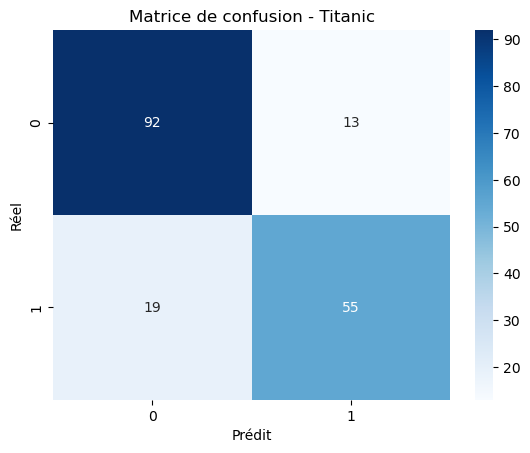

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Titanic')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()